In [1]:
import numpy as np

import pandas as pd
import sys, os, time
from scipy.stats import norm
import matplotlib.pyplot as plt

%matplotlib inline

sys.path.append('../')

from src.data_structures import FactorGraph, PriorityQueue
from src.sampling_algorithms.factor_components import (gaussian_bounce, chain_bounce_fn, 
                                                       gaussian_grad_potential_fn, 
                                                       gaussian_chain_grad_potential_fn,
                                                       logistic, 
                                                       generate_logistic_bounce, 
                                                       alias_sample, 
                                                       lambda_r, 
                                                       grad_logistic, 
                                                       lambda_bound
                                                      )
from src.utils import (interp, get_xtv, get_first_moment, get_second_moment, get_var)
from src.sampling_algorithms import LocalBPS
from src.plots.arrow_plot import arrow_plot
from arviz.stats import ess
 
from matplotlib import rc
rc('text', usetex=False)

In [2]:
np.random.seed(0)
d = 2
groups = 1
N = 100


beta0 = 0.
betas = []
observations = []
covs = []

for g in range(groups):
    beta = beta0 + 4*np.random.randn(d)
    betas.append(beta)
    
    cov = np.random.rand(d*N).reshape(N,d)*2.-1.
    covs.append(cov)
    p = logistic(cov.dot(beta))
    y = (np.random.random(len(p)) < p)+0.
    observations.append(y)
    
covs = np.array(covs)
observations = np.array(observations)

cov_p = np.maximum(0., covs)
cov_n = -np.minimum(0., covs)
sign = np.expand_dims((-1.)**observations, -1)

In [4]:
cov_n.shape

(1, 100, 2)

In [5]:
mu0 = np.array([0. for _ in range(d)])
sig0 = np.diag([1. for _ in range(d)])
mu1 = np.array([0. for _ in range(d)])
sig1 = sig0 + sig0
sig10 = sig0

global_event_samplers = []
local_event_samplers = []

for g in range(groups):
    global_event_samplers.append(chain_bounce_fn(mu1, mu0, sig1, sig0, sig10))
    local_event_samplers.append(alias_sample(g, cov_n, cov_p, covs, sign, observations))
    
bounce_fns = [gaussian_bounce(mu0, sig0)] + global_event_samplers + local_event_samplers

grad_factor_potential_fns = [gaussian_grad_potential_fn(mu0, sig0)] + \
                            [gaussian_chain_grad_potential_fn(mu1, mu0, sig1, sig10, sig0) for _ in range(groups)] + \
                            [grad_logistic(covs[g], observations[g]) for g in range(groups)]

factor_indices = [[i for i in range(d)]] + \
                 [[i for i in range(d)]+[d + d*i +j for j in range(d)] for i in range(groups)] + \
                 [[d + d*i +j for j in range(d)] for i in range(groups)] 

factor_potential_fns = [lambda x: x for _ in grad_factor_potential_fns]

nodes = list(set(n for f in factor_indices for n in f ))

graph = FactorGraph(dim_x=len(nodes),
                  factor_indices=factor_indices,
                  factor_potential_fns=factor_potential_fns,
                  grad_factor_potential_fns=grad_factor_potential_fns)

In [6]:
np.random.seed(0)

init_x_dict = {'mu_0': np.array(2.13799408),
 'mu_1': np.array(0.61352211),
 'beta_1': np.array(4.27598974),
 'beta_2': np.array(1.22704567)}

In [7]:
init_x = np.array([2.13799408, 0.61352211, 4.27598974, 1.22704567])

In [8]:
init_v = np.random.randn(len(nodes))

In [9]:
local_bps = LocalBPS(init_x = init_x,
         init_v = init_v,
         factor_graph = graph,
         bounce_fns=bounce_fns,
         refresh_rate=0.001)

In [10]:
start = time.time()
nsim= 10**5
results = local_bps.simulate(nsim)
res = results
duration = time.time()-start
print(duration)

100%|██████████| 100000/100000 [00:14<00:00, 6752.07it/s]


15.026376247406006


In [11]:
burnin = 10**3
res[burnin:].shape

(99001, 3, 4)

In [12]:
coef_betas = []
betas_flat = np.array(betas).flatten()
for i in range(len(nodes)):
    x1,v1,t1=get_xtv(res[burnin:],i)
    if i < d:
        beta = beta0
    else:
        beta = betas_flat[i-d]
    b = get_first_moment(x1, v1, t1)
    coef_betas.append(b)
    print('Beta {0}: {1} vs {2}'.format(i, beta,b))
coef_betas = np.array(coef_betas)

Beta 0: 0.0 vs 0.4047999683895138
Beta 1: 0.0 vs 0.10785878584722064
Beta 2: 7.056209383870656 vs 0.7938916269461662
Beta 3: 1.6006288334688932 vs 0.15666304501770612


In [23]:
coef_betas

array([0.40479997, 0.10785879, 0.79389163, 0.15666305])

In [24]:
ps = logistic(covs[0].dot(coef_betas[d:]))

In [25]:
np.min(ps), np.max(ps)

(0.30457860760365046, 0.704018473067689)

In [16]:
for i in range(len(nodes)):
    x1,v1,t1=get_xtv(res,i)
    x = interp(x1,t1,v1, num_intervals=nsim*5)
    print('ESS {0}: {1}'.format('bulk',ess(x, method='bulk')/duration))
    print('ESS {0}: {1}'.format('tail',ess(x, method='tail')/duration))

ESS bulk: 34.55419709470405
ESS tail: 45.1918317865203
ESS bulk: 37.29331285351291
ESS tail: 37.96312070178079
ESS bulk: 26.9968087601635
ESS tail: 34.1368905992034
ESS bulk: 27.64356554640256
ESS tail: 41.88579506029888


In [17]:
x1,v1,t1=get_xtv(res,0)
x2,v2,t2=get_xtv(res,1)

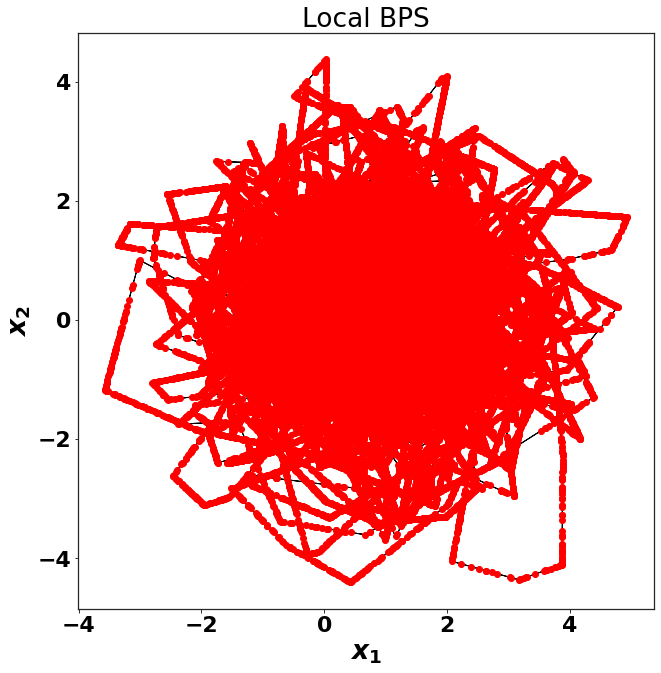

In [18]:
x1,v1,t1=get_xtv(res,2)
x2,v2,t2=get_xtv(res,3)
burnin = 1000
plot_limit = 100000
fig_size = (10,10)
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.25

font = {
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)


fig = plt.figure(figsize=fig_size,frameon =True)
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height])
ax.set_title("Local BPS")
ax.set_xlabel("$x_1$",fontsize='large', fontweight='bold')
ax.set_ylabel("$x_2$",fontsize='large', fontweight='bold')
arrow_plot(x1[burnin:burnin+plot_limit],x2[burnin:burnin+plot_limit], head_length=0.01,head_width=0.01)
fig.savefig('./local_bps.eps', format='eps', dpi=1200)



In [19]:
x1,v1,t1=get_xtv(res[1000:],2)

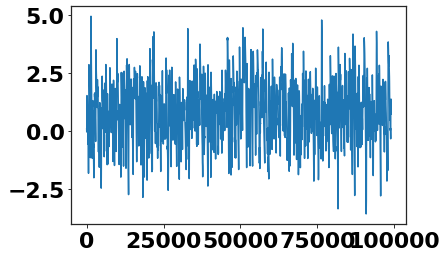

In [20]:
plt.plot(x1)

In [21]:
np.mean(x1)

0.8402111863223761

In [22]:
np.std(x1)

1.2614872128817731